In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from timefusion import TimeFusion
import random
import torch
from torch import nn


In [2]:
# Create dataset of two correlated, random walks on top of sine functions
# Set random seed to make result reproducible
np.random.seed(0)

# Random walk starts at 0,0
z = np.array([0,0])

# Covariance matrix for normal distribution
cov = [
    [1, 0.5],
    [0.5, 1]
]

# List to hold samples
samples = []

for i in range(60000):

    # Calculate underlying sine values
    y = 150*np.array([np.sin(i/40),np.sin((i/25))])
    #y = 1*np.array([np.sin(0.04*i),np.sin(0.04*i)])

    # Draw random samples from normal distribution
    z = np.random.multivariate_normal(z,cov)
    #z = np.array([0,0])

    # Store samples
    samples.append(y + z)

# Create pandas DataFrame out of data
data = pd.DataFrame(data=samples,columns=["sine1","sine2"])

# Remove 50% of samples to make into an irregular time-series
keep = 0.20 # What fraction of cells to keep
mask = [False]*int(2*len(data)*keep) + [True]*int(2*len(data)*(1-keep))
random.shuffle(mask)
mask = np.array(mask).reshape((len(data),2))
data = data.mask(mask)

# Remove all rows without any data
data = data.dropna(axis = 0, how = 'all')


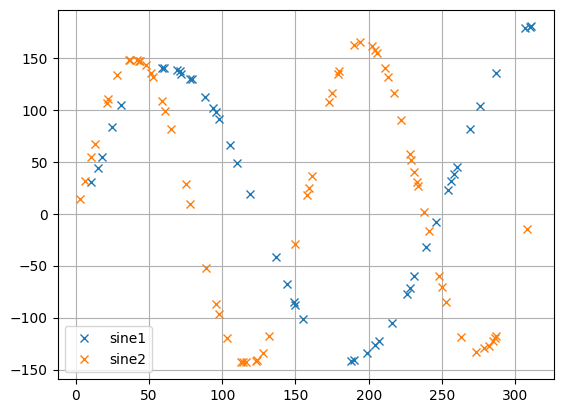

In [3]:
# Plot data so we can inspect it
data[:100].plot(marker="x",linewidth=0)
plt.grid(True)

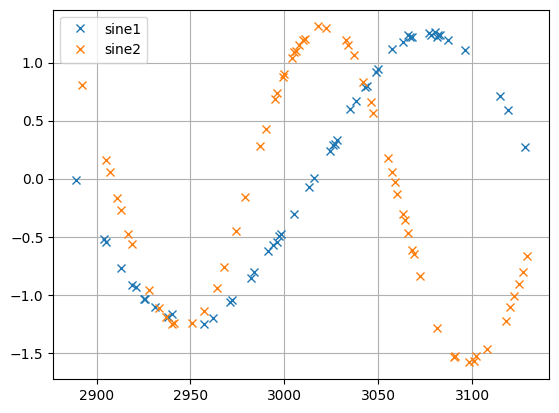

In [4]:
# Detrend data by subtracting running mean and dividing by running variance
#data - data.rolling(200).mean()
data -= data.rolling(100,min_periods=30).mean()
data /= data.rolling(200,min_periods=60).std()

data = data[1000:]

# Replot data
data[:100].plot(marker='x',linewidth=0)
plt.grid(True)

In [5]:
predictor = TimeFusion(
    datapoint_dim = 3,
    time_series_dim=2,
    context_length = 50,
    prediction_length = 30,
    device = torch.device("mps"),
    diff_steps=100,
    dim_feedforward=128,
    num_decoder_layers=2,
    num_encoder_layers=2,
    nhead=1,
    d_model=128,
)

In [6]:
print("Number of trainable parameters:",sum(p.numel() for p in predictor.parameters()))

Number of trainable parameters: 1801404


In [7]:
predictor.train(
    train_data=data[:int(0.1*len(data))],
    epochs=60,
    val_data=data[int(0.95*len(data)):],
    val_metrics= {
        "Val MAE": nn.L1Loss(),
        "Val MSE": nn.MSELoss()
    },
    optimizer=torch.optim.Adam(params=predictor.parameters(),lr=1e-4)
)

 |==============================|  Batch: 30 / 30, Epoch: 1 / 60, Average Loss: 1.0515, Val MAE: 0.7847, Val MSE: 0.9698


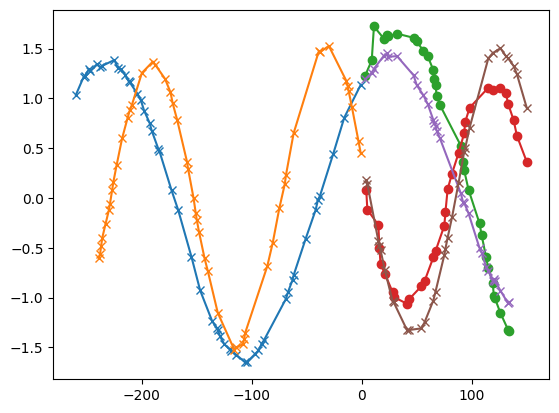

In [18]:
sample_index = 5000

timestamps = []

for column in data.columns:
    timestamps.append(list(data[sample_index:][column].dropna().index[:predictor.prediction_length]))

timestamps = np.array(timestamps)

samples = predictor.sample(
    data=data[:sample_index],
    timestamps=timestamps,
    num_samples=64,
    batch_size=64
)

plt.plot(data[:sample_index]['sine1'].dropna().index[-predictor.context_length:] - data[:sample_index].index[-1] - 1,list(data[:sample_index]['sine1'].dropna()[-predictor.context_length:]),"-x")
plt.plot(data[:sample_index]['sine2'].dropna().index[-predictor.context_length:] - data[:sample_index].index[-1]  - 1,list(data[:sample_index]['sine2'].dropna()[-predictor.context_length:]),"-x")
#plt.plot(samples[0,0].cpu())
#plt.plot(samples[0,1].cpu())
plt.plot(timestamps[0] - data[:sample_index].index[-1],torch.mean(samples.cpu(),axis=0)[0],"-o")
plt.plot(timestamps[1] - data[:sample_index].index[-1],torch.mean(samples.cpu(),axis=0)[1],"-o")

plt.plot(timestamps[0] - data[:sample_index].index[-1],list(data[sample_index:]['sine1'].dropna()[:predictor.prediction_length]),"-x")
plt.plot(timestamps[1] - data[:sample_index].index[-1],list(data[sample_index:]['sine2'].dropna()[:predictor.prediction_length]),"-x")

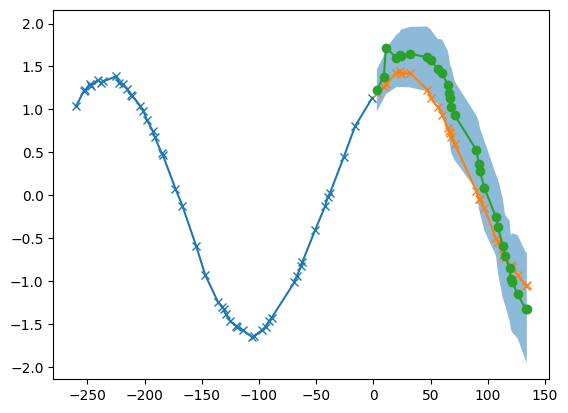

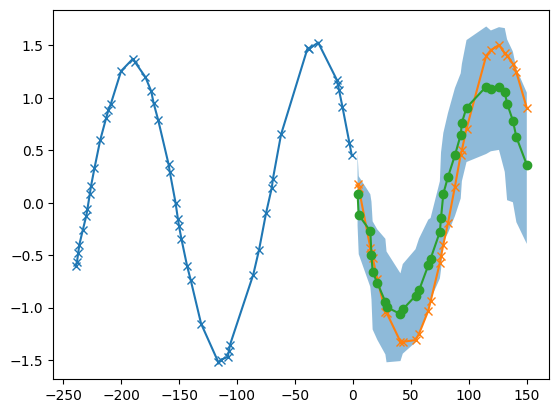

In [61]:
confidence = 0.1

samples_cpu = samples.cpu()
samples_cpu[:,0,:], _= torch.sort(samples_cpu[:,0,:],dim=0)
samples_cpu[:,1,:], _ = torch.sort(samples_cpu[:,1,:],dim=0)

plt.figure()
plt.plot(data[:sample_index]['sine1'].dropna().index[-predictor.context_length:] - data[:sample_index].index[-1] - 1,list(data[:sample_index]['sine1'].dropna()[-predictor.context_length:]),"-x")
plt.plot(timestamps[0] - data[:sample_index].index[-1],list(data[sample_index:]['sine1'].dropna()[:predictor.prediction_length]),"-x")
plt.fill_between(timestamps[0] - data[:sample_index].index[-1],samples_cpu[int(confidence*samples_cpu.shape[0]),0,:], samples_cpu[int((1-confidence)*samples_cpu.shape[0]),0,:],alpha=0.5)
plt.plot(timestamps[0] - data[:sample_index].index[-1],torch.mean(samples.cpu(),axis=0)[0],"-o")

plt.figure()
plt.plot(data[:sample_index]['sine2'].dropna().index[-predictor.context_length:] - data[:sample_index].index[-1] - 1,list(data[:sample_index]['sine2'].dropna()[-predictor.context_length:]),"-x")
plt.plot(timestamps[1] - data[:sample_index].index[-1],list(data[sample_index:]['sine2'].dropna()[:predictor.prediction_length]),"-x")
plt.fill_between(timestamps[1] - data[:sample_index].index[-1],samples_cpu[int(confidence*samples_cpu.shape[0]),1,:], samples_cpu[int((1-confidence)*samples_cpu.shape[0]),1,:],alpha=0.5)
plt.plot(timestamps[1] - data[:sample_index].index[-1],torch.mean(samples.cpu(),axis=0)[1],"-o")